# Model Implementation: LSTM

## Libraries

In [4]:
pip install contractions

  Using cached contractions-0.1.73-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached textsearch-0.0.24-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached anyascii-0.3.2-py3-none-any.whl.metadata (1.5 kB)
  Using cached pyahocorasick-2.1.0-cp312-cp312-win_amd64.whl.metadata (13 kB)
Using cached contractions-0.1.73-py2.py3-none-any.whl (8.7 kB)
Using cached textsearch-0.0.24-py2.py3-none-any.whl (7.6 kB)
Using cached anyascii-0.3.2-py3-none-any.whl (289 kB)
Using cached pyahocorasick-2.1.0-cp312-cp312-win_amd64.whl (39 kB)
Note: you may need to restart the kernel to use updated packages.


In [23]:
import keras_tuner as kt
import nltk
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from nltk.corpus import stopwords
from NN_preprocessing import *
from utils import *

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

print("EarlyStopping initialized successfully!")

EarlyStopping initialized successfully!


In [22]:
pip install --upgrade tensorflow

In [8]:
pip install torchtools

Note: you may need to restart the kernel to use updated packages.


In [24]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\naomi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Uploading

In [40]:
train_df =  pd.read_csv('C:/Users/naomi/emotion-detection-txa/Model Implementation/data/train_yangswei_85.csv')
test_df =  pd.read_csv('C:/Users/naomi/emotion-detection-txa/Model Implementation/data/test_yangswei_85.csv')

## Preprocessing

### Train

In [41]:
train_df['text'].apply(preprocess).to_frame()

# Tokenize and pad training data

padded_sequences, train_vocabulary, vocab_size = tokenize_and_pad(train_df[['text']])

# Set training data

train_data = padded_sequences

### Test

In [42]:
test_df['text'].apply(preprocess).to_frame()  

# Tokenize and pad test data

padded_sequences, _, _ = tokenize_and_pad(test_df[['text']], train_vocabulary)

# Set test data

test_data = padded_sequences

### Encoding

In [43]:
#Encoding labels for keras

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_df['label'])
num_classes = len(set(y_train_encoded))
y_train_encoded_cat = to_categorical(y_train_encoded, num_classes=num_classes)

In [44]:
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(test_df['label'])
num_classes = len(set(y_test_encoded))
y_test_encoded_cat = to_categorical(y_test_encoded, num_classes=num_classes)

## The Model

### Tuning

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=hp.Choice('output_dim', [64, 128, 256])))
    model.add(LSTM(hp.Int('lstm_units1', min_value=64, max_value=256, step=64), return_sequences=True))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(LSTM(hp.Int('lstm_units2', min_value=32, max_value=128, step=32)))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [23]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=25,  
    executions_per_trial=2,  
    directory='tuner_results',
    project_name='emotion_classification'
)

c:\Users\naomi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
tuner.search(train_data, y_train_encoded_cat, epochs=7, validation_split=0.2, batch_size=32)

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hps.values)

### Implementation

In [45]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida de validación
    patience=3,          # Detiene el entrenamiento después de 3 épocas sin mejora
    restore_best_weights = True  # Restaura los pesos del modelo a la mejor época
)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=256))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(96))     
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))  

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(train_data, y_train_encoded_cat, epochs=20, batch_size=64, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 468s 369ms/step - accuracy: 0.5958 - loss: 1.1763 - val_accuracy: 0.6021 - val_loss: 1.1351
Epoch 2/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 494s 394ms/step - accuracy: 0.6008 - loss: 1.1513 - val_accuracy: 0.6017 - val_loss: 1.1151
Epoch 3/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 481s 383ms/step - accuracy: 0.6783 - loss: 0.9311 - val_accuracy: 0.7952 - val_loss: 0.5859
Epoch 4/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 403s 321ms/step - accuracy: 0.8352 - loss: 0.4739 - val_accuracy: 0.8212 - val_loss: 0.5008
Epoch 5/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 376s 300ms/step - accuracy: 0.9012 - loss: 0.2942 - val_accuracy: 0.8161 - val_loss: 0.5491
Epoch 6/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 367s 292ms/step - accuracy: 0.9348 - loss: 0.1964 - val_accuracy: 0.8121 - val_loss: 0.5862
Epoch 7/20
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 370s 295ms/step - accuracy: 0.9536 - loss: 0.1405 - val_accuracy: 0.8162 - val_loss: 0.6571


In [46]:
# Evaluate the model

loss, accuracy = model.evaluate(test_data, y_test_encoded_cat)
print(f'Test Accuracy: {accuracy:.4f}')

697/697 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - accuracy: 0.8211 - loss: 0.5010
Test Accuracy: 0.8222


In [47]:
y_pred_prob = model.predict(test_data)

y_pred = np.argmax(y_pred_prob, axis=1)

y_test_1d = np.argmax(y_test_encoded_cat, axis=1)
y_test_1d

697/697 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step


array([2, 2, 1, ..., 2, 4, 4])

In [48]:
# Save the model in HDF5 format

model.save('model_lstm.h5')  

In [49]:
y_test_decoded = label_encoder.inverse_transform(y_test_1d)  
y_pred_decoded = label_encoder.inverse_transform(y_pred)

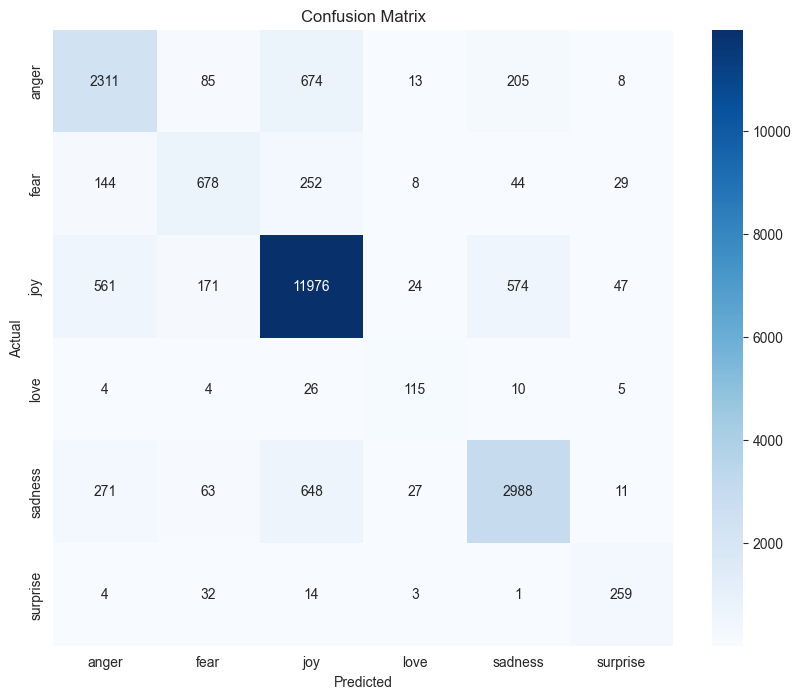

In [50]:
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

sns.set_style("white")
sns.set_palette("pastel")

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [51]:
print(classification_report(y_test_decoded, y_pred_decoded))

              precision    recall  f1-score   support

       anger       0.70      0.70      0.70      3296
        fear       0.66      0.59      0.62      1155
         joy       0.88      0.90      0.89     13353
        love       0.61      0.70      0.65       164
     sadness       0.78      0.75      0.76      4008
    surprise       0.72      0.83      0.77       313

    accuracy                           0.82     22289
   macro avg       0.72      0.74      0.73     22289
weighted avg       0.82      0.82      0.82     22289

